# Machine Learning Coursework U1901363

In [1]:
# Importing the modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal



## Dataset (A)

In [2]:
# Read into the iris data set

df = pd.read_csv('iris.data', header=None) # Make sure iris.data is in the working directory
df.columns = ['S_len','S_wid','P_len','P_wid','Type']
df2 = df.drop('Type',axis=1)
df

,S_len,S_wid,P_len,P_wid,Type
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


## Data visualization (B)


          PC1       PC2            Type
0   -2.684207 -0.326607     Iris-setosa
1   -2.715391  0.169557     Iris-setosa
2   -2.889820  0.137346     Iris-setosa
3   -2.746437  0.311124     Iris-setosa
4   -2.728593 -0.333925     Iris-setosa
..        ...       ...             ...
145  1.944017 -0.187415  Iris-virginica
146  1.525664  0.375021  Iris-virginica
147  1.764046 -0.078519  Iris-virginica
148  1.901629 -0.115877  Iris-virginica
149  1.389666  0.282887  Iris-virginica

[150 rows x 3 columns]


(-3, 2)

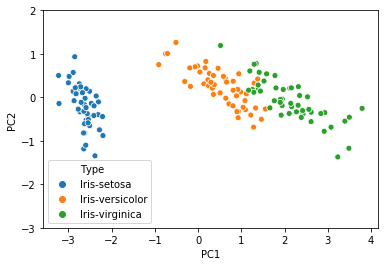

In [3]:
# Centering the columns so that the column means are zero

def centering_df(df):
    """
    centering_df will calculate column mean for each column and then each element in that column will subtract the column mean
    
    :param df: the dataframe with numeric columns that need to be centered
    
    :return: returns the centered dataframe  
    
    """
    
    for column in df.columns:
        mean = df[column].mean()
        df[column] = (df[column] - mean)
    return df
    
    

def pca(df):
    """
    pca will center the dataframe and then return the values in dataframe as the linear combination of the two most significant principal components 
    
    :param df: dataframe of numeric values that need pca done on
    
    :return: returns the dataframe represented by the two most significant principal components.
    
    """
    
    centering_df(df)        
    u,s,v = np.linalg.svd(df, full_matrices=True)
    u = u[:,0:2]
    u[:,0] = u[:,0]*s[0]
    u[:,1] = u[:,1]*s[1]
    return u

      

    
# Visualizing the data-points in 2 dimensions using the two most significant principal components with their correct label.
coords = pca(df2)
SVD_plot = pd.DataFrame(coords)
SVD_plot['Type'] = df['Type']
SVD_plot.columns = ['PC1', 'PC2','Type']

print(SVD_plot)


ax = sns.scatterplot(x='PC1',y='PC2',hue='Type', data=SVD_plot)
ax.set_ylim(-3,2)


## Clustering using GMM and the EM algorithm (C)

### Clustering using K-Means (C-1)

(-4, 4)

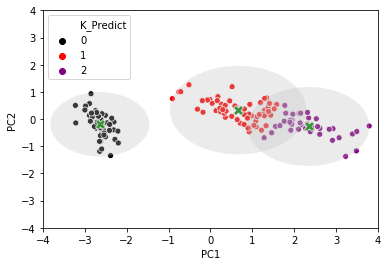

In [4]:
# Setting seed so clusters are the same
my_seed = 54

# Computing predictions using k-means from sklearn 
km = KMeans(n_clusters=3,random_state=my_seed)

km.fit(SVD_plot[['PC1','PC2']])

SVD_plot['K_Predict'] = km.labels_
color_dict_K = dict({0: 'Black',1:'Red',2:'Purple'})

ax = sns.scatterplot(x='PC1',y='PC2',hue='K_Predict', data=SVD_plot, palette=color_dict_K)

centers = km.cluster_centers_

# Computing the distances from each point from each cluster to their respective centers and finding the max for each cluster to assign to each cluster radius
radius_list = [cdist(SVD_plot[SVD_plot['K_Predict']==i][['PC1','PC2']], [center]).max() for i,center in enumerate(centers)]

# Display cluster centres
sns.scatterplot(centers[:,0], centers[:,1], marker='X', s=100, alpha=1, color = 'green')


# Display shapes of the clusters
for center,radius1 in zip(centers,radius_list):
    ax.add_patch(plt.Circle(center, radius=radius1,fc='#C0C0C0',alpha=0.3))
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)




### Accuracy of K-Means (C-2)

In [5]:
ct = pd.crosstab(SVD_plot['Type'],SVD_plot['K_Predict'])
print(ct)

accuracy = round((ct[0].max()+ct[1].max()+ct[2].max())*100/len(SVD_plot),2)
print("The accuracy of K-Means is",accuracy,"%")

#### Find the centroid of the types then assign each 'label' to the nearest type and then calculate accuracy

K_Predict         0   1   2
Type                       
Iris-setosa      50   0   0
Iris-versicolor   0  47   3
Iris-virginica    0  14  36
The accuracy of K-Means is 88.67 %


### Initial values for EM-algorithm using K-Means (C-3)

In [6]:
## EM algo initial find the mean,covariance and prob of each cluster 

initial_cluster_prob = [len(SVD_plot[SVD_plot['K_Predict']==cluster])/len(SVD_plot) for cluster in SVD_plot['K_Predict'].unique()]

initial_mean = [SVD_plot[SVD_plot['K_Predict']==cluster][['PC1','PC2']].mean() for cluster in SVD_plot['K_Predict'].unique()]

initial_cov = [SVD_plot[SVD_plot['K_Predict']==cluster][['PC1','PC2']].cov() for cluster in SVD_plot['K_Predict'].unique()]

theta_KM = [[initial_cluster_prob[0],initial_mean[0],initial_cov[0]],[initial_cluster_prob[1],initial_mean[1],initial_cov[1]],[initial_cluster_prob[2],initial_mean[2],initial_cov[2]]]

print('Initial parameters:{',theta_KM[0],'}')
print('Initial parameters:{',theta_KM[1],'}')
print('Initial parameters:{',theta_KM[2],'}')

Initial parameters:{ [0.3333333333333333, PC1   -2.640841
PC2   -0.190520
dtype: float64,           PC1       PC2
PC1  0.048745 -0.057049
PC2 -0.057049  0.219106] }
Initial parameters:{ [0.26, PC1    2.346451
PC2   -0.272355
dtype: float64,           PC1       PC2
PC1  0.360808 -0.108511
PC2 -0.108511  0.135611] }
Initial parameters:{ [0.4066666666666667, PC1    0.664434
PC2    0.330292
dtype: float64,           PC1       PC2
PC1  0.384046 -0.111685
PC2 -0.111685  0.147374] }


### Implementation of the EM algorithm (C-4)

In [7]:
## Responsibilities/ E STEP calcluates the responsibilities for each point for each cluster

def responsibilities(matrix,cluster_list,pi_cluster,mean_cluster,cov_cluster):
    """
    responsibilities calculates the responsibilities of each point to each cluster
    
    :param1 matrix: the numeric dataframe containing the points that you want to calculate the responsiblities to each cluster
    :param2 cluster_list: the list of clusters
    :param3 pi_cluster: list containing the probability to belong in each cluster
    :param4 mean_cluster: list containing the centres of each cluster
    :param5 cov_cluster: list containing the covariance matrix of each cluster
    
    :return: list of responsibilities of each point for each cluster
    """
    
    
    # Creates a list of multivariate normal distributions with the params list
    multi_dists = [multivariate_normal(mean=mean_cluster[cluster],cov=cov_cluster[cluster]) for cluster in cluster_list]
    response_all = []
    response_cluster = []
    for cluster in cluster_list:

        for i in range(len(matrix)):
            #calulates the responsibilites for each point for cluster
            prob_given_theta = (multi_dists[cluster].pdf(matrix[['PC1','PC2']].iloc[i]))*pi_cluster[cluster]/(sum([multi_dists[cluster_all].pdf(matrix[['PC1','PC2']].iloc[i])*pi_cluster[cluster_all] for cluster_all in cluster_list]))
            response_cluster.append(prob_given_theta)
        response_all.append(response_cluster)
        response_cluster = []
    return response_all

In [8]:
## M step to calculate the next iteration of parameters (probability,means,covariance matrix)


def M_step(X,responsibility):
    """
    M_step calculates the next parameters for the clusters based on the responsibilities
    
    :param1 X: The dataframe of numeric values (coordinates)
    :param2 responsibility: list containing the responsibilities of each point for each cluster
    
    
    :return: returns the next set of parameters for the cluster (probabilities, centres, covariance matrices) 
    
    """
    
    
    cluster_prob = [(sum(cluster)/len(X)) for cluster in responsibility]
    
    # Multiplies each row of X with respective responsibilities and sums then divides by sum of clusters
    mean_cluster = [((X[['PC1','PC2']]*(np.array(cluster).reshape(150,1))).sum())/(sum(cluster)) for cluster in responsibility]
    
    cov_list =[]

    # Calculating the next iteration of covariance matrix using the formula
    for mu_i,cluster in enumerate(responsibility):
        sum_equ =0
        for i,row in X[['PC1','PC2']].iterrows():
            sum_equ += (np.dot((np.array(row)-np.array(mean_cluster[mu_i])).reshape(2,1), ((np.array(row)-np.array(mean_cluster[mu_i])).reshape(1,2)))*((np.array(cluster[i]))))
    

        cov_list.append(sum_equ/sum(cluster))
    
    
    return cluster_prob,mean_cluster,cov_list


In [9]:
def likelihood(X,responsibility,prob,mean_cluster,cov_cluster):
    """
    likelihood calculates the negative complete log-likelihood
    
    :param1 X: The dataframe of numeric values (coordinates)
    :param2 responsibility: list containing the responsibilities of each point for each cluster
    :param3 prob: list containing the probability to belong in each cluster
    :param4 mean_cluster: list containing the centres of each cluster
    :param5 cov_cluster: list containing the covariance matrix of each cluster
    
    :return: returns the negative complete log-likelihood for those parameters in the model
    
    """
    
    
    n=0
    # Creates a list of multivariate normal distributions with the params list
    multi_dists = [multivariate_normal(mean=mean_cluster[cluster_dist],cov=cov_cluster[cluster_dist]) for cluster_dist in X['K_Predict'].unique()]
    
    for i,row in X[['PC1','PC2']].iterrows():
        s=0
        for j,cluster in enumerate(responsibility):
            # Summing over points calucluating the log-likelihood
            s += math.log(prob[j]*(multi_dists[j].pdf(row))/cluster[i])
        n += s  
    return -n
            


In [10]:
## EM-ALGORITHM

def EM_algo(X,prob1,mean1,cov1,steps):
    """
    EM_algo iterates through the E-Step and M-Step until the number of steps reached
    
    :param1 X: The dataframe of numeric values (coordinates)
    :param2 prob1: list containing the initial probability to belong in each cluster
    :param3 mean1: list containing the initial centres of each cluster
    :param4 cov1: list containing the initial covariance matrix of each cluster
    
    :return: returns the parameters for each cluster after steps reached
    
    """
    
    # Calls the steps and iterates those steps
    
    r_c_i = responsibilities(X,X['K_Predict'].unique(),prob1,mean1,cov1)
    likelihood_2 = []
    for i in range(steps):
        prob,mean,cov = M_step(X,r_c_i)
        r_c_i = responsibilities(X,X['K_Predict'].unique(),prob,mean,cov)
        likelihood_2.append(likelihood(X,r_c_i,prob,mean,cov))
        
    
    return prob,mean,cov,r_c_i,likelihood_2


### Final set of parameters (C-5) 

In [11]:
# Calculating 20 iterations using EM-Algorithm
p20,m20,c20,r_c_i_o_20,likelihood20 = EM_algo(SVD_plot,initial_cluster_prob,initial_mean,initial_cov,20)
p20,m20,c20

theta = [[p20[0],m20[0],c20[0]],[p20[1],m20[1],c20[1]],[p20[2],m20[2],c20[2]]]

print('Final parameters:{',theta[0],'}')
print('Final parameters:{',theta[1],'}')
print('Final parameters:{',theta[2],'}')

Final parameters:{ [0.3333333333333021, PC1   -2.640841
PC2   -0.190520
dtype: float64, array([[ 0.04777048, -0.05590782],
       [-0.05590782,  0.21472356]])] }
Final parameters:{ [0.34745028070642475, PC1    2.048053
PC2   -0.021971
dtype: float64, array([[ 0.54838261, -0.29269576],
       [-0.29269576,  0.23444209]])] }
Final parameters:{ [0.3192163859602732, PC1    0.52843
PC2    0.22286
dtype: float64, array([[ 0.37282055, -0.21720721],
       [-0.21720721,  0.18631807]])] }


### Accuracy of the cluster assignment by EM-Algorithm (C-6)

In [12]:
def prediction_EM(r_c_i_op):
    """
    prediction_EM will assign hard values to point to each cluster based on which cluster had the highest responsibilities for each point
    
    :param1 r_c_i_op: the list of final responsibilites of each point to each cluster
    
    :return: returns the list of predictions for each point to each cluster
    
    """
    prediction_list = []
    for i in range(len(r_c_i_op[0])):
        # Checks which cluster had the highest responsibility for each point
        if ((r_c_i_op[0][i] > r_c_i_op[1][i]) and (r_c_i_op[0][i] > r_c_i_op[2][i])):
            prediction_list.append(0)
        elif ((r_c_i_op[1][i] > r_c_i_op[0][i]) and (r_c_i_op[1][i] > r_c_i_op[2][i])):
            prediction_list.append(2)
        else:
            prediction_list.append(1)
    return prediction_list

In [13]:
# Creates a crosstab between EM-predict and the Type and will calculate accuracy based on values outside the biggest type groups for each cluster

EM_predict = prediction_EM(r_c_i_o_20)
SVD_plot['EM_predict'] = EM_predict
ct2 = pd.crosstab(SVD_plot['Type'],SVD_plot['EM_predict'])
print(ct2)

accuracy2 = round((ct2[0].max()+ct2[1].max()+ct2[2].max())*100/len(SVD_plot),2)
print("The accuracy of using EM-algorithm to assign clusters is",accuracy2,"%")


EM_predict        0   1   2
Type                       
Iris-setosa      50   0   0
Iris-versicolor   0  47   3
Iris-virginica    0   1  49
The accuracy of using EM-algorithm to assign clusters is 97.33 %


### Display cluster assignment by EM-Algorithm (C-7)

In [14]:
from matplotlib.patches import Ellipse
import numpy as np
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    # Draw the Ellipse
    for nsig in range(1, 5):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, **kwargs))

(-3.8, 5)

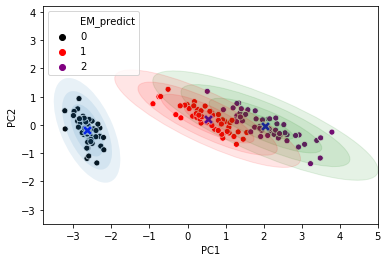

In [15]:

color_dict_K = dict({0: 'Black',1:'Red',2:'Purple'})

ax = sns.scatterplot(x='PC1',y='PC2',hue='EM_predict', data=SVD_plot, palette=color_dict_K)
sns.scatterplot(x=np.array(m20)[:,0], y=np.array(m20)[:,1], marker='X', s=100, alpha=1, color = 'blue')
draw_ellipse(m20[0],c20[0],alpha=0.1)
draw_ellipse(m20[1],c20[1],alpha=0.1,color= 'green')
draw_ellipse(m20[2],c20[2],alpha=0.1,color='red')

ax.set_ylim(-3.5,4.2)
ax.set_xlim(-3.8,5)



### DISCUSSION OF CONVERGENCE (C-8)

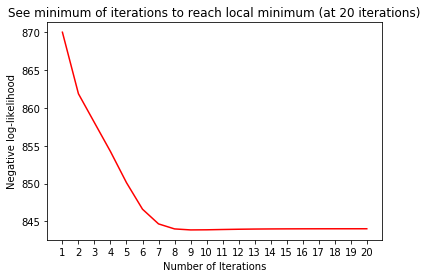

In [16]:
import numpy as np
import matplotlib.pyplot as plt
 
# data to be plotted
x1 = np.arange(1,21)
x2 = np.arange(1, 81)

# fig,axs = plt.subplots(2)
 
# plotting
plt.title("See minimum of iterations to reach local minimum (at 20 iterations)")
plt.xlabel("Number of Iterations")
plt.ylabel("Negative log-likelihood")
plt.xticks(np.arange(min(x1), max(x1)+1, 1))
plt.plot(x1, likelihood20, color ="red")





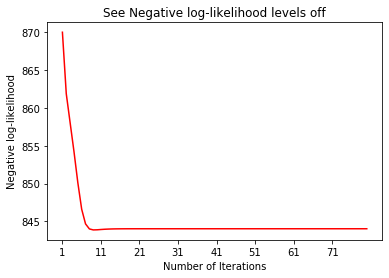

In [17]:
# Calculating 80 iterations
p100,m100,c100,r_c_i_o_100,likelihood100 = EM_algo(SVD_plot,initial_cluster_prob,initial_mean,initial_cov,80)

plt.title("See Negative log-likelihood levels off")
plt.xlabel("Number of Iterations")
plt.ylabel("Negative log-likelihood")
plt.xticks(np.arange(min(x2), max(x2)+1, 10))
plt.plot(x2, likelihood100, color ="red")
plt.show()

### Discussion about accuracy of K-Means compared to EM-Algorithm (C-9)

In [18]:
print(ct)
print("The accuracy of K-Means is",accuracy,"% \n")
print(ct2)
print("The accuracy of using EM-algorithm to assign clusters is",accuracy2,"%")



K_Predict         0   1   2
Type                       
Iris-setosa      50   0   0
Iris-versicolor   0  47   3
Iris-virginica    0  14  36
The accuracy of K-Means is 88.67 % 

EM_predict        0   1   2
Type                       
Iris-setosa      50   0   0
Iris-versicolor   0  47   3
Iris-virginica    0   1  49
The accuracy of using EM-algorithm to assign clusters is 97.33 %
